In [36]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s3e22/sample_submission.csv
/kaggle/input/playground-series-s3e22/train.csv
/kaggle/input/playground-series-s3e22/test.csv


In [37]:
!pip install klib

In [38]:
# Data manipulation and preprocessing
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

# Statistical tests
from scipy.stats import chi2_contingency

# Machine learning models and metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix

# Deep learning libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

# Model persistence
import pickle
import joblib

# Data visualization
import matplotlib.pyplot as plt



In [39]:
traindata = pd.read_csv('/kaggle/input/playground-series-s3e22/train.csv')
testdata  = pd.read_csv('/kaggle/input/playground-series-s3e22/test.csv')
submissiondata = pd.read_csv('/kaggle/input/playground-series-s3e22/sample_submission.csv')



# Exploratory Data Analysis - EDA

In [40]:
traindata

,id,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,...,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data,outcome
0,0,yes,adult,530001,38.1,132.0,24.0,cool,reduced,dark_cyanotic,...,57.0,8.5,serosanguious,3.4,yes,2209,0,0,no,died
1,1,yes,adult,533836,37.5,88.0,12.0,cool,normal,pale_cyanotic,...,33.0,64.0,serosanguious,2.0,yes,2208,0,0,no,euthanized
2,2,yes,adult,529812,38.3,120.0,28.0,cool,reduced,pale_pink,...,37.0,6.4,serosanguious,3.4,yes,5124,0,0,no,lived
3,3,yes,adult,5262541,37.1,72.0,30.0,cold,reduced,pale_pink,...,53.0,7.0,cloudy,3.9,yes,2208,0,0,yes,lived
4,4,no,adult,5299629,38.0,52.0,48.0,normal,normal,normal_pink,...,47.0,7.3,cloudy,2.6,no,0,0,0,yes,lived
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1230,1230,yes,adult,535246,38.5,129.0,48.0,cool,reduced,pale_pink,...,57.0,66.0,serosanguious,2.0,yes,2206,0,0,no,lived
1231,1231,yes,adult,528570,37.5,60.0,50.0,cool,reduced,pale_cyanotic,...,35.0,6.4,serosanguious,3.6,yes,2209,0,0,yes,died
1232,1232,yes,young,529685,37.5,84.0,40.0,normal,reduced,normal_pink,...,40.0,5.9,cloudy,7.0,yes,400,0,0,yes,lived
1233,1233,yes,adult,534784,38.1,70.0,16.0,normal,reduced,bright_red,...,58.0,74.0,cloudy,2.0,yes,2209,0,0,no,lived


GridSpec(6, 6)

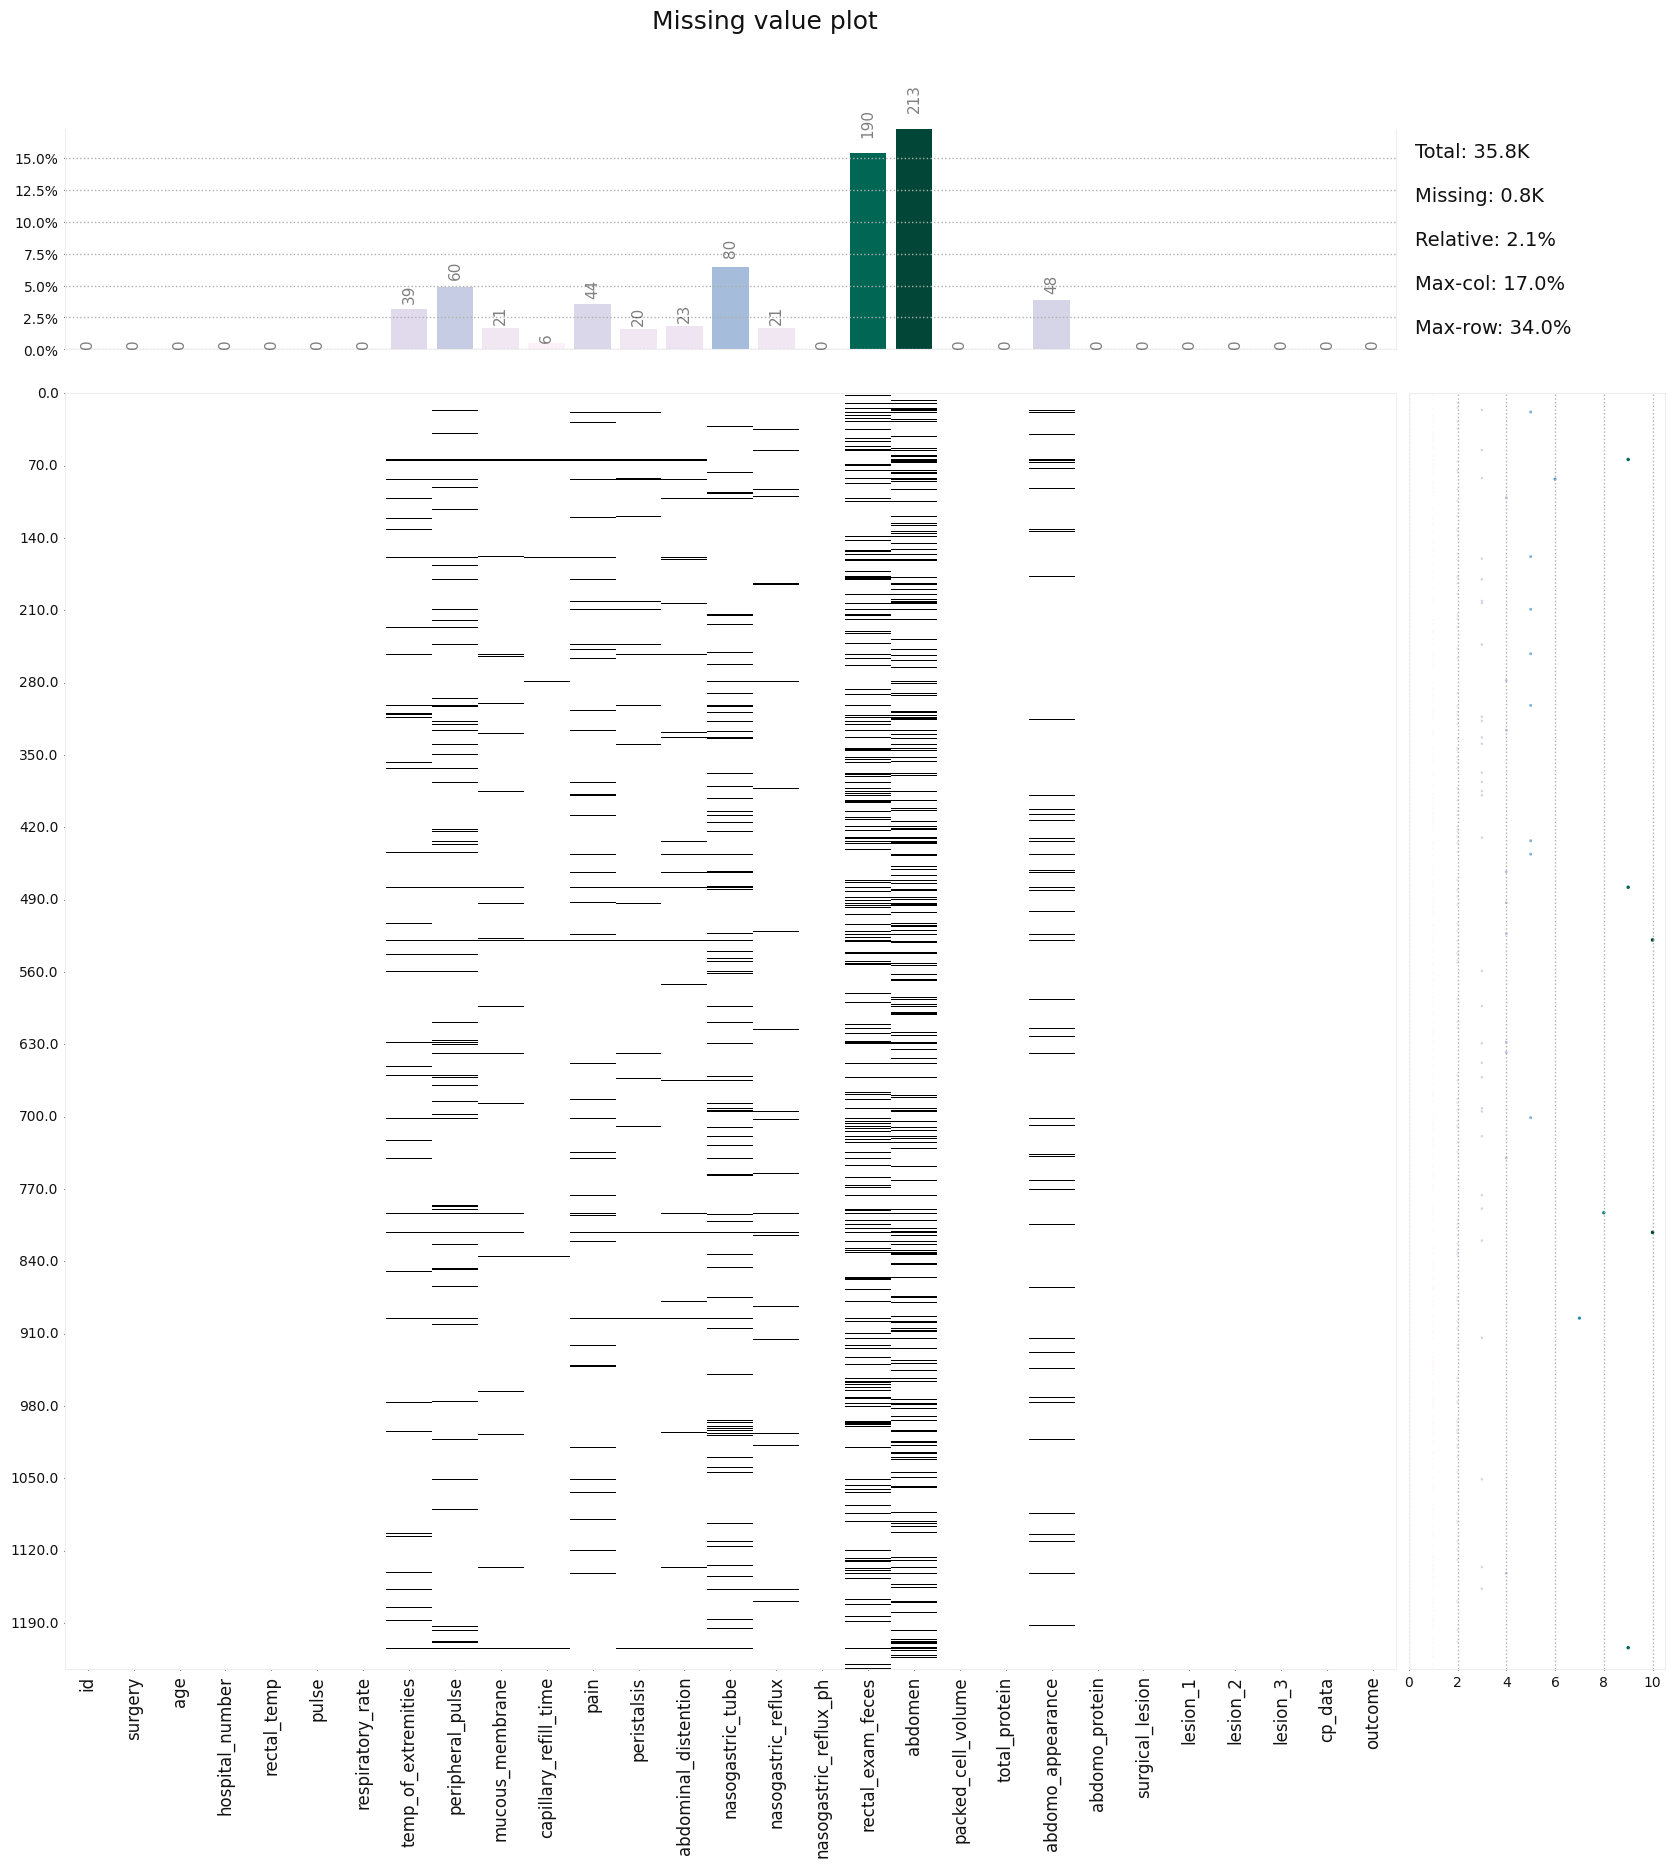

In [41]:
klib.missingval_plot(traindata)

### *Removing unnecessary columns*

In [42]:
traindata.drop(['id','hospital_number'],axis =1, inplace = True)
testdata.drop (['id','hospital_number'],axis =1, inplace = True)

In [43]:
print(traindata.info())
print(testdata.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1235 entries, 0 to 1234
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   surgery                1235 non-null   object 
 1   age                    1235 non-null   object 
 2   rectal_temp            1235 non-null   float64
 3   pulse                  1235 non-null   float64
 4   respiratory_rate       1235 non-null   float64
 5   temp_of_extremities    1196 non-null   object 
 6   peripheral_pulse       1175 non-null   object 
 7   mucous_membrane        1214 non-null   object 
 8   capillary_refill_time  1229 non-null   object 
 9   pain                   1191 non-null   object 
 10  peristalsis            1215 non-null   object 
 11  abdominal_distention   1212 non-null   object 
 12  nasogastric_tube       1155 non-null   object 
 13  nasogastric_reflux     1214 non-null   object 
 14  nasogastric_reflux_ph  1235 non-null   float64
 15  rect

#### *Regarding the columns of lesion_1, lesion_2 and lesion_3*

Since those are categorical variables, need to convert to object or category type variables

In [44]:
lesion_columns = ['lesion_1', 'lesion_2', 'lesion_3']

def convert_int_to_object(data, columns):
    for column in columns:
        if data[column].dtype == 'int64':
            data[column] = data[column].astype('object')


convert_int_to_object(traindata, lesion_columns)
convert_int_to_object(testdata, lesion_columns)

In [45]:
categorical_columns = traindata.select_dtypes(include=['object', 'category']).columns.tolist()
traindata[categorical_columns]

,surgery,age,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,pain,peristalsis,abdominal_distention,nasogastric_tube,nasogastric_reflux,rectal_exam_feces,abdomen,abdomo_appearance,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data,outcome
0,yes,adult,cool,reduced,dark_cyanotic,more_3_sec,depressed,absent,slight,slight,less_1_liter,decreased,distend_small,serosanguious,yes,2209,0,0,no,died
1,yes,adult,cool,normal,pale_cyanotic,more_3_sec,mild_pain,absent,moderate,none,more_1_liter,absent,distend_small,serosanguious,yes,2208,0,0,no,euthanized
2,yes,adult,cool,reduced,pale_pink,less_3_sec,extreme_pain,hypomotile,moderate,slight,none,NaN,distend_large,serosanguious,yes,5124,0,0,no,lived
3,yes,adult,cold,reduced,pale_pink,more_3_sec,mild_pain,hypomotile,moderate,slight,more_1_liter,decreased,distend_small,cloudy,yes,2208,0,0,yes,lived
4,no,adult,normal,normal,normal_pink,less_3_sec,alert,hypomotile,none,slight,less_1_liter,normal,normal,cloudy,no,0,0,0,yes,lived
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1230,yes,adult,cool,reduced,pale_pink,more_3_sec,depressed,absent,moderate,none,more_1_liter,NaN,distend_large,serosanguious,yes,2206,0,0,no,lived
1231,yes,adult,cool,reduced,pale_cyanotic,less_3_sec,mild_pain,hypomotile,slight,slight,none,decreased,distend_small,serosanguious,yes,2209,0,0,yes,died
1232,yes,young,normal,reduced,normal_pink,less_3_sec,mild_pain,hypomotile,slight,slight,none,increased,firm,cloudy,yes,400,0,0,yes,lived
1233,yes,adult,normal,reduced,bright_red,less_3_sec,mild_pain,hypomotile,slight,none,more_1_liter,absent,distend_small,cloudy,yes,2209,0,0,no,lived


In [46]:
quantitative_columns = traindata.select_dtypes(include=['float64', 'int64', 'category']).columns.tolist()
traindata[quantitative_columns]

,rectal_temp,pulse,respiratory_rate,nasogastric_reflux_ph,packed_cell_volume,total_protein,abdomo_protein
0,38.1,132.0,24.0,6.5,57.0,8.5,3.4
1,37.5,88.0,12.0,2.0,33.0,64.0,2.0
2,38.3,120.0,28.0,3.5,37.0,6.4,3.4
3,37.1,72.0,30.0,2.0,53.0,7.0,3.9
4,38.0,52.0,48.0,7.0,47.0,7.3,2.6
...,...,...,...,...,...,...,...
1230,38.5,129.0,48.0,2.0,57.0,66.0,2.0
1231,37.5,60.0,50.0,3.0,35.0,6.4,3.6
1232,37.5,84.0,40.0,3.0,40.0,5.9,7.0
1233,38.1,70.0,16.0,2.0,58.0,74.0,2.0


In [47]:
traindata.info()
testdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1235 entries, 0 to 1234
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   surgery                1235 non-null   object 
 1   age                    1235 non-null   object 
 2   rectal_temp            1235 non-null   float64
 3   pulse                  1235 non-null   float64
 4   respiratory_rate       1235 non-null   float64
 5   temp_of_extremities    1196 non-null   object 
 6   peripheral_pulse       1175 non-null   object 
 7   mucous_membrane        1214 non-null   object 
 8   capillary_refill_time  1229 non-null   object 
 9   pain                   1191 non-null   object 
 10  peristalsis            1215 non-null   object 
 11  abdominal_distention   1212 non-null   object 
 12  nasogastric_tube       1155 non-null   object 
 13  nasogastric_reflux     1214 non-null   object 
 14  nasogastric_reflux_ph  1235 non-null   float64
 15  rect

In [48]:
df = traindata

In [49]:
categorical_columns = df.select_dtypes(include=['object']).columns

for column in categorical_columns[:-1]:
    print(column, testdata[column].unique())

surgery ['no' 'yes']
age ['adult' 'young']
temp_of_extremities ['normal' 'cool' nan 'cold' 'warm']
peripheral_pulse ['normal' 'reduced' nan 'absent' 'increased']
mucous_membrane ['normal_pink' 'bright_pink' 'bright_red' 'pale_cyanotic' 'dark_cyanotic'
 'pale_pink' nan]
capillary_refill_time ['less_3_sec' 'more_3_sec' nan '3']
pain ['mild_pain' 'depressed' 'severe_pain' 'extreme_pain' nan 'moderate'
 'alert']
peristalsis ['hypomotile' 'absent' 'hypermotile' nan 'normal']
abdominal_distention ['slight' 'moderate' 'severe' 'none' nan]
nasogastric_tube ['none' 'slight' nan 'significant']
nasogastric_reflux ['none' 'more_1_liter' 'less_1_liter' nan]
rectal_exam_feces ['normal' 'decreased' 'absent' nan 'increased']
abdomen ['distend_small' 'distend_large' nan 'other' 'firm' 'normal']
abdomo_appearance ['clear' 'serosanguious' 'cloudy' nan]
surgical_lesion ['no' 'yes']
lesion_1 [0 2208 2205 1400 2207 2209 4205 2124 3205 2112 2206 3111 5400 31110 400
 8400 2322 5000 12208 2305 2111 37 7209 300

## Univariate analysis

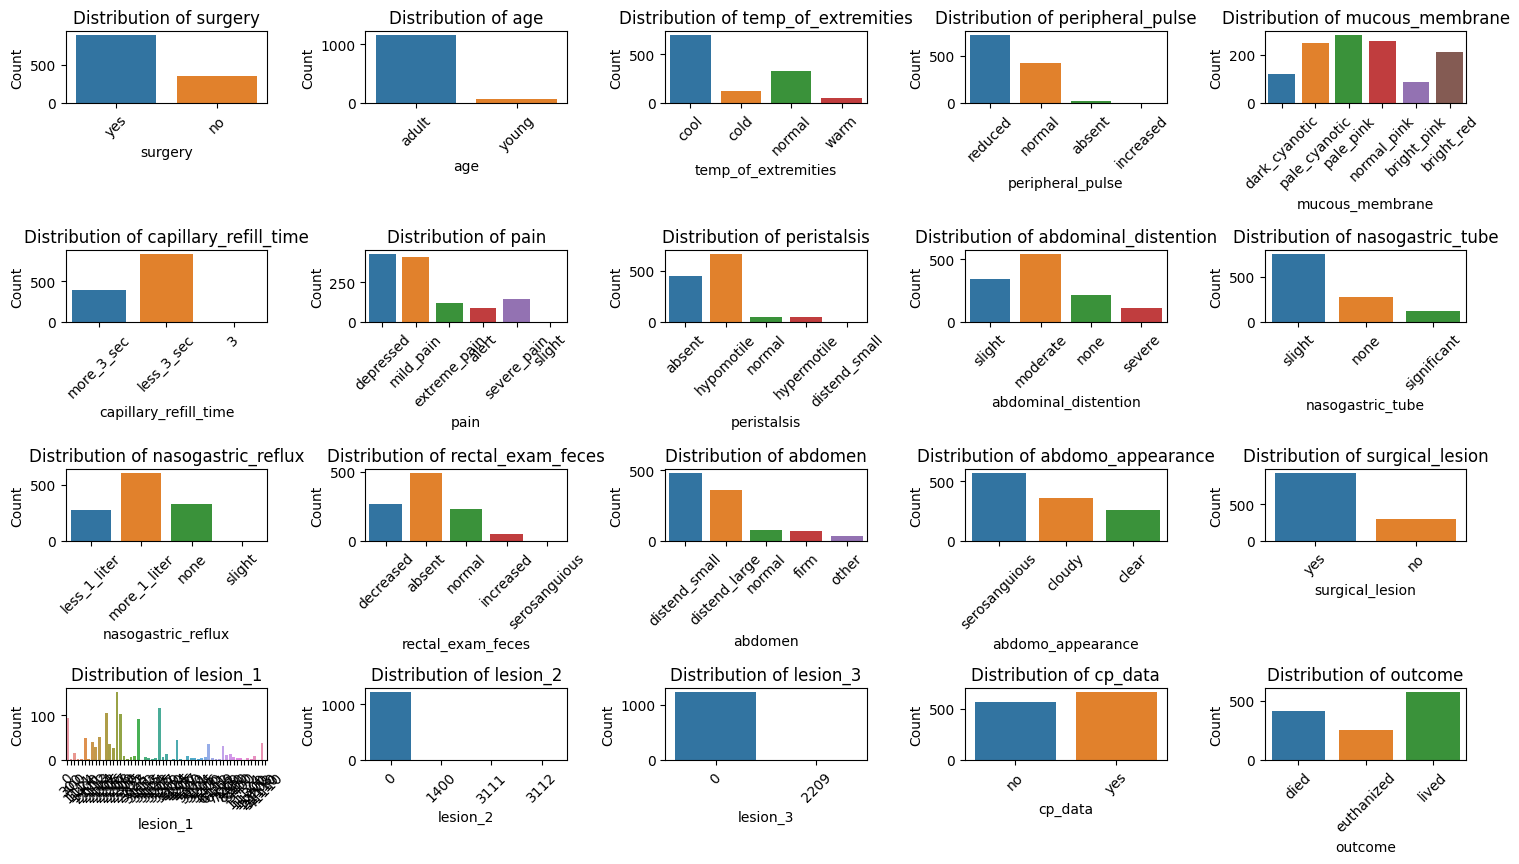

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

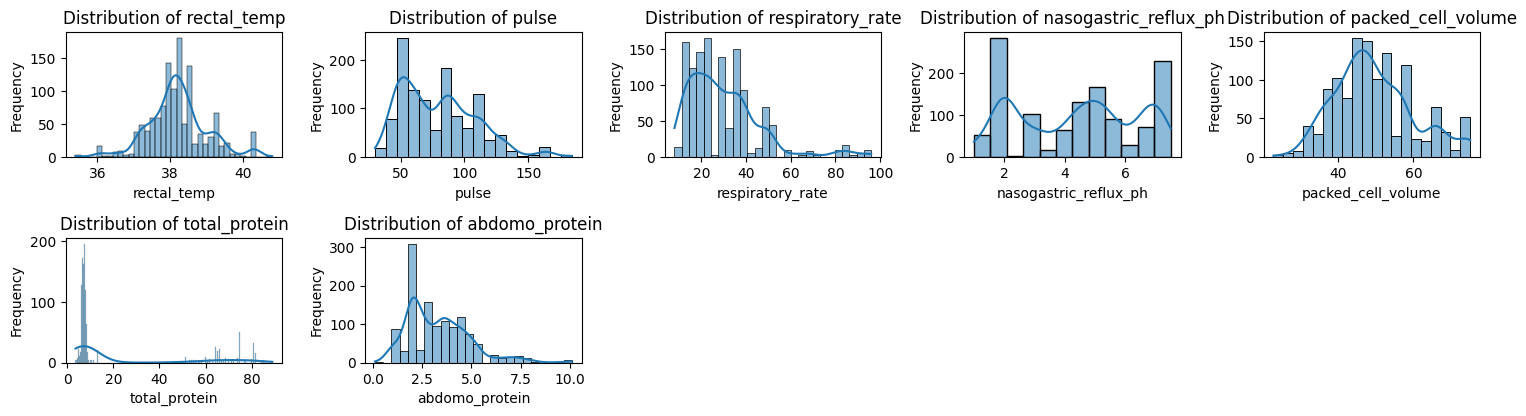

In [50]:
# Define a function for univariate analysis of categorical variables
def univariate_categorical_analysis(data, column, ax):
    sns.countplot(data=data, x=column, ax=ax)
    ax.set_title(f'Distribution of {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Count')
    ax.tick_params(axis='x', rotation=45)

# Define a function for univariate analysis of numeric variables
def univariate_numeric_analysis(data, column, ax):
    sns.histplot(data=data, x=column, kde=True, ax=ax)
    ax.set_title(f'Distribution of {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Frequency')

num_rows = 5
num_cols = 5
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))

# Univariate analysis for categorical variables
categorical_columns = df.select_dtypes(include=['object', 'category']).columns
for i, column in enumerate(categorical_columns):
    row = i // num_cols
    col = i % num_cols
    univariate_categorical_analysis(df, column, ax=axes[row, col])

# Remove any unused subplots
for i in range(len(categorical_columns), num_rows*num_cols):
    row = i // num_cols
    col = i % num_cols
    fig.delaxes(axes[row, col])

# Adjust layout
plt.tight_layout()
plt.show()

# Set up the subplots grid for numeric variables
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))

# Univariate analysis for numeric variables
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
for i, column in enumerate(numeric_columns):
    row = i // num_cols
    col = i % num_cols
    univariate_numeric_analysis(df, column, ax=axes[row, col])

# Remove any unused subplots
for i in range(len(numeric_columns), num_rows*num_cols):
    row = i // num_cols
    col = i % num_cols
    fig.delaxes(axes[row, col])

# Adjust layout
plt.tight_layout()
plt.show()

#### analysing the outcome variable class balance - dependent variable class balance

In [51]:
df['outcome'].value_counts()

outcome
lived         574
died          410
euthanized    251
Name: count, dtype: int64

### seems to be ok, so dont need to balance the dataset.

## Bivariate analysis

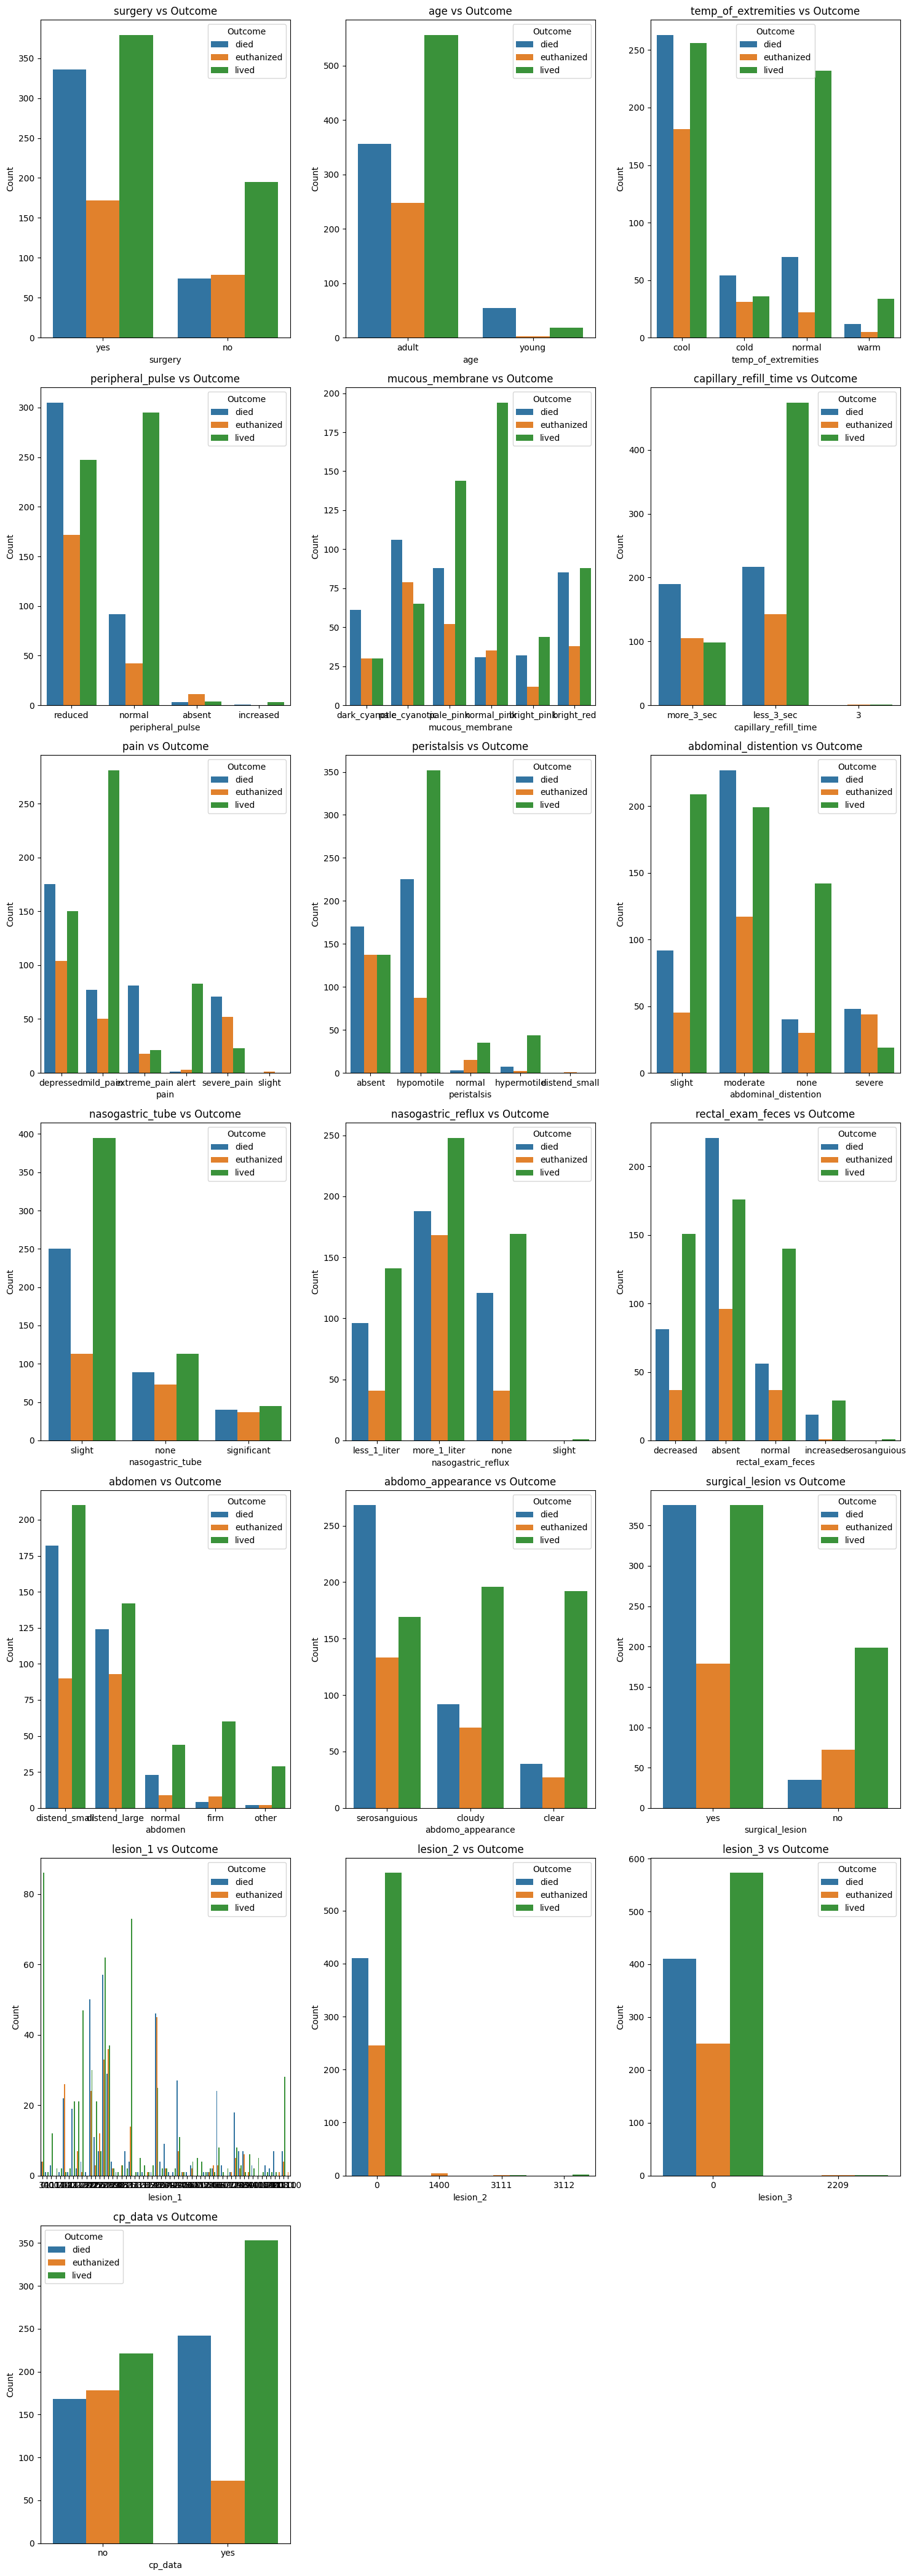

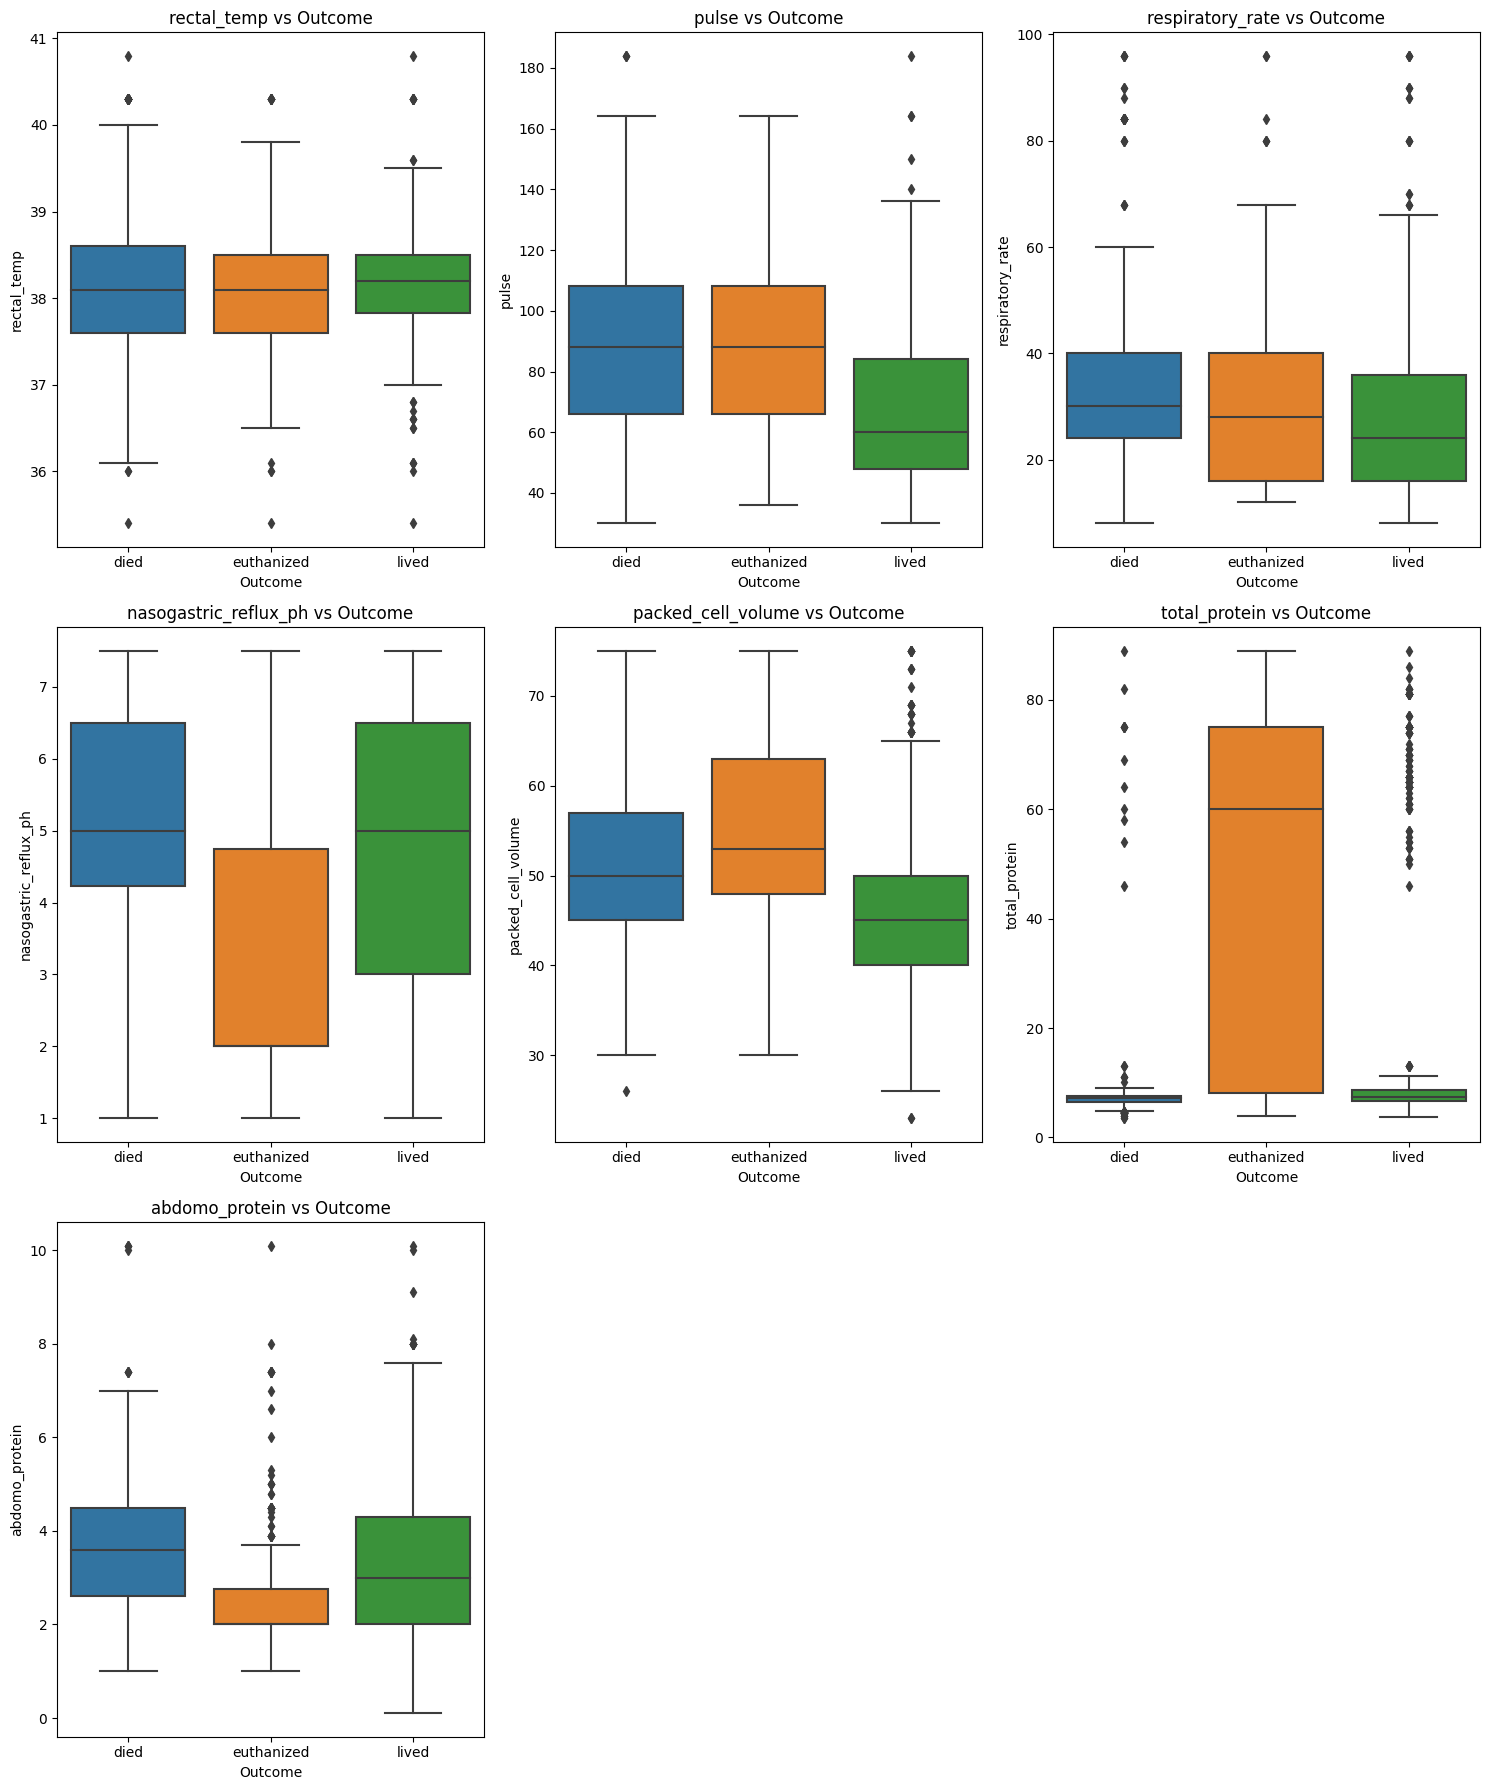

In [52]:
# Define a function for bivariate analysis of categorical variables with 'outcome'
def bivariate_categorical_outcome_analysis(data, column, ax):
    sns.countplot(data=data, x=column, hue='outcome', ax=ax)
    ax.set_title(f'{column} vs Outcome')
    ax.set_xlabel(column)
    ax.set_ylabel('Count')
    ax.legend(title='Outcome')

# Define a function for bivariate analysis of numeric variables with 'outcome'
def bivariate_numeric_outcome_analysis(data, column, ax):
    sns.boxplot(data=data, x='outcome', y=column, ax=ax)
    ax.set_title(f'{column} vs Outcome')
    ax.set_xlabel('Outcome')
    ax.set_ylabel(column)

# Set up the subplots grid for categorical variables with 'outcome'
num_cols = 3
num_rows = (len(df.select_dtypes(include=['object', 'category']).columns) - 1) // num_cols + 1
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 6*num_rows))

# Bivariate analysis for categorical variables with 'outcome'
categorical_columns = df.select_dtypes(include=['object', 'category']).columns
for i, column in enumerate(categorical_columns):
    if column != 'outcome':
        row = i // num_cols
        col = i % num_cols
        bivariate_categorical_outcome_analysis(df, column, ax=axes[row, col])

# Remove any unused subplots
for i in range(len(categorical_columns)-1, num_rows*num_cols):
    row = i // num_cols
    col = i % num_cols
    fig.delaxes(axes[row, col])

# Adjust layout
plt.tight_layout()
plt.show()

# Set up the subplots grid for numeric variables with 'outcome'
num_cols = 3
num_rows = (len(df.select_dtypes(include=['float64', 'int64']).columns)) // num_cols + 1
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 6*num_rows))

# Bivariate analysis for numeric variables with 'outcome'
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
for i, column in enumerate(numeric_columns):
    row = i // num_cols
    col = i % num_cols
    bivariate_numeric_outcome_analysis(df, column, ax=axes[row, col])

# Remove any unused subplots
for i in range(len(numeric_columns), num_rows*num_cols):
    row = i // num_cols
    col = i % num_cols
    fig.delaxes(axes[row, col])

# Adjust layout
plt.tight_layout()
plt.show()

## Multivariate analysis

<Axes: title={'center': 'Feature-correlation (pearson)'}>

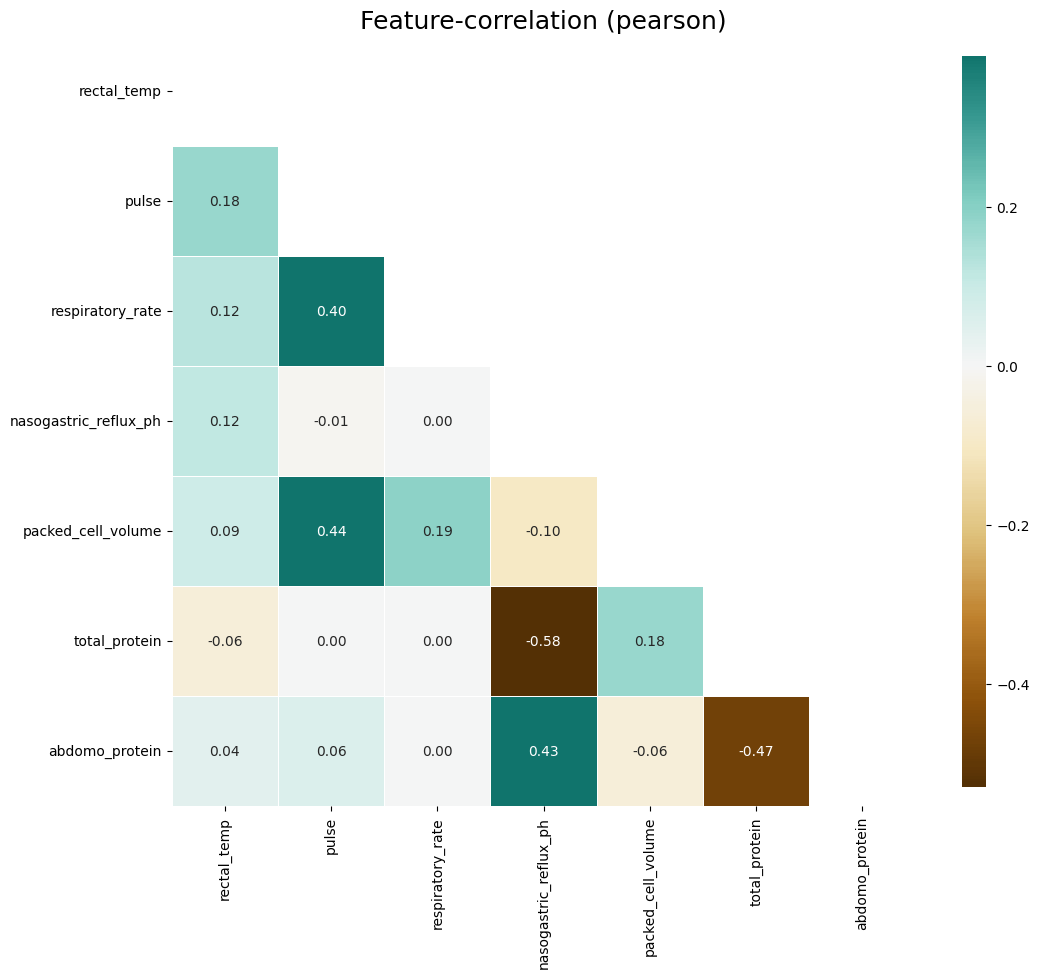

In [53]:
klib.corr_plot(df)

#### *There is a considerable negative correlation between total_protein variable and nasogastic_reflux_ph variables. And also there is a positive correlation between abdomo_protein and nasogastic_reflux_ph variables.*

#### *Also there can be seen some negative correlation of total_protein with abdomo_protein.*

#### *Respiratory rate and pulse variables have a positive correlation of 0.4*

#### **So when doing advance analysis or model building we need to focus of those correlation variables. if needed we must omit the correlated variables.**

### *Test of association for categorical variables*

In [54]:
import pandas as pd
from scipy.stats import chi2_contingency

# Load the dataset
data = df  # Replace 'your_dataset.csv' with the path to your dataset

# Drop rows with missing values
data.dropna(inplace=True)

# Select only categorical columns
categorical_cols = data.select_dtypes(include=['object']).columns

# Create an empty DataFrame to store the p-values
p_values = pd.DataFrame(index=categorical_cols, columns=categorical_cols)

# Compute p-values for all pairs of categorical variables
for col1 in categorical_cols:
    for col2 in categorical_cols:
        if col1 != col2:
            contingency_table = pd.crosstab(data[col1], data[col2])
            _, p_value, _, _ = chi2_contingency(contingency_table)
            p_values.loc[col1, col2] = p_value

# Function to highlight significant p-values
def highlight_significant(val):
    color = 'background-color: pink' if float(val) < 0.05 else ''
    return color

# Apply formatting to p-values DataFrame
formatted_p_values = p_values.style.applymap(highlight_significant)

# Display the formatted p-values
print("p-values with significant cells highlighted:")
formatted_p_values

p-values with significant cells highlighted:


/tmp/ipykernel_33/3946350850.py:30: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  formatted_p_values = p_values.style.applymap(highlight_significant)


,surgery,age,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,pain,peristalsis,abdominal_distention,nasogastric_tube,nasogastric_reflux,rectal_exam_feces,abdomen,abdomo_appearance,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data,outcome
surgery,nan,0.907006,0.000000,0.000000,0.000000,0.268521,0.000000,0.000000,0.000000,0.275364,0.315908,0.000000,0.000000,0.000001,0.000000,0.000000,0.185316,0.930547,0.000004,0.000288
age,0.907006,nan,0.165886,0.269027,0.210690,0.176557,0.033184,0.999640,0.104649,0.103819,0.517160,0.105996,0.039722,0.091262,0.204089,0.026630,0.944832,1.000000,0.222660,0.002053
temp_of_extremities,0.000000,0.165886,nan,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001871,0.003398,0.000000,0.000000,0.000000,0.000000,0.000000,0.682061,0.707265,0.003694,0.000000
peripheral_pulse,0.000000,0.269027,0.000000,nan,0.000000,0.000000,0.000000,0.000000,0.000000,0.003533,0.211634,0.000000,0.000000,0.000000,0.000000,0.001447,0.819987,0.731225,0.000047,0.000000
mucous_membrane,0.000000,0.210690,0.000000,0.000000,nan,0.000000,0.000000,0.000000,0.000000,0.000009,0.040040,0.000000,0.000000,0.000000,0.000000,0.000000,0.407627,0.230180,0.000012,0.000000
capillary_refill_time,0.268521,0.176557,0.000000,0.000000,0.000000,nan,0.000000,0.000000,0.000000,0.000052,0.452790,0.000006,0.000113,0.000000,0.000079,0.002372,0.853727,0.639103,0.000002,0.000000
pain,0.000000,0.033184,0.000000,0.000000,0.000000,0.000000,nan,0.000000,0.000000,0.000001,0.022807,0.000000,0.000000,0.000000,0.000000,0.000000,0.970050,0.949091,0.000007,0.000000
peristalsis,0.000000,0.999640,0.000000,0.000000,0.000000,0.000000,0.000000,nan,0.000000,0.090144,0.000019,0.000000,0.000000,0.000000,0.000000,0.000000,0.539277,0.220480,0.000000,0.000000
abdominal_distention,0.000000,0.104649,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,nan,0.000000,0.280818,0.000000,0.000000,0.000000,0.000000,0.000000,0.251443,0.537245,0.000014,0.000000
nasogastric_tube,0.275364,0.103819,0.001871,0.003533,0.000009,0.000052,0.000001,0.090144,0.000000,nan,0.120315,0.000002,0.092929,0.010174,0.045936,0.000886,0.812340,0.564007,0.000609,0.000142


# Advanced analysis - ML model building

In [55]:
data

,surgery,age,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,pain,...,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data,outcome
0,yes,adult,38.1,132.0,24.0,cool,reduced,dark_cyanotic,more_3_sec,depressed,...,57.0,8.5,serosanguious,3.4,yes,2209,0,0,no,died
1,yes,adult,37.5,88.0,12.0,cool,normal,pale_cyanotic,more_3_sec,mild_pain,...,33.0,64.0,serosanguious,2.0,yes,2208,0,0,no,euthanized
3,yes,adult,37.1,72.0,30.0,cold,reduced,pale_pink,more_3_sec,mild_pain,...,53.0,7.0,cloudy,3.9,yes,2208,0,0,yes,lived
4,no,adult,38.0,52.0,48.0,normal,normal,normal_pink,less_3_sec,alert,...,47.0,7.3,cloudy,2.6,no,0,0,0,yes,lived
5,no,adult,38.1,56.0,32.0,normal,normal,bright_pink,less_3_sec,depressed,...,49.0,8.0,cloudy,2.8,no,0,0,0,yes,lived
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1228,yes,adult,38.3,48.0,20.0,normal,normal,bright_pink,more_3_sec,depressed,...,41.0,65.0,clear,2.0,yes,3111,0,0,no,lived
1229,yes,adult,38.0,136.0,20.0,cool,reduced,bright_red,less_3_sec,depressed,...,66.0,65.0,serosanguious,2.0,yes,2208,0,0,no,lived
1231,yes,adult,37.5,60.0,50.0,cool,reduced,pale_cyanotic,less_3_sec,mild_pain,...,35.0,6.4,serosanguious,3.6,yes,2209,0,0,yes,died
1232,yes,young,37.5,84.0,40.0,normal,reduced,normal_pink,less_3_sec,mild_pain,...,40.0,5.9,cloudy,7.0,yes,400,0,0,yes,lived


## SVM model

Accuracy: 0.7032258064516129
F1-Score: 0.6976970865167168
Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.78      0.71        59
           1       0.62      0.38      0.47        21
           2       0.77      0.73      0.75        75

    accuracy                           0.70       155
   macro avg       0.68      0.63      0.64       155
weighted avg       0.70      0.70      0.70       155



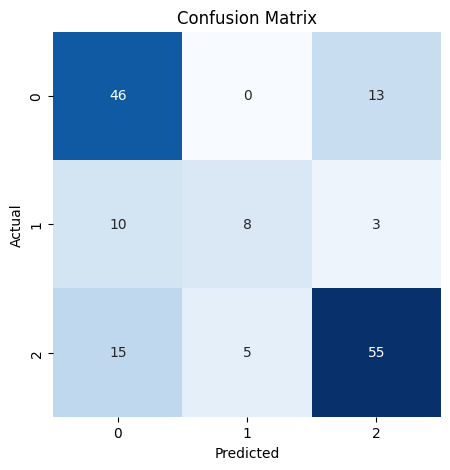

In [56]:
# Load the dataset
data = df

# Drop rows with missing values
data.dropna(inplace=True)

# Convert categorical variables to numerical using LabelEncoder
label_encoders = {}
for column in data.select_dtypes(include=['object']).columns:
    label_encoders[column] = LabelEncoder()
    data[column] = label_encoders[column].fit_transform(data[column])

# Split data into features and target variable
X = data.drop('outcome', axis=1)
y = data['outcome']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the SVM model
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = svm_model.predict(X_test)

# Evaluate the model
accuracy_svm = accuracy_score(y_test, y_pred)
f1_svm = f1_score(y_test, y_pred, average='weighted')

print("Accuracy:", accuracy_svm)
print("F1-Score:",f1_svm)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot heatmap
plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Logistic model

Accuracy: 0.6838709677419355
F1-Score: 0.6797236919968247
Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.71      0.67        59
           1       0.53      0.38      0.44        21
           2       0.76      0.75      0.75        75

    accuracy                           0.68       155
   macro avg       0.64      0.61      0.62       155
weighted avg       0.68      0.68      0.68       155



/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


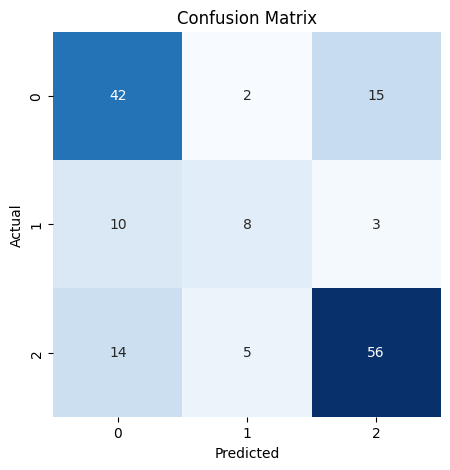

In [57]:
# Load the dataset
data = df 

# Drop rows with missing values
data.dropna(inplace=True)

# Separate features and target variable
X = data.drop('outcome', axis=1)
y = data['outcome']

# Identify categorical columns
categorical_columns = X.select_dtypes(include=['object']).columns

# Apply one-hot encoding to categorical columns
transformer = ColumnTransformer(transformers=[('onehot', OneHotEncoder(), categorical_columns)], remainder='passthrough')
X_encoded = transformer.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Train the logistic regression model
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train, y_train)


# Make predictions on the testing set
y_pred = logistic_model.predict(X_test)

accuracy_logistic = accuracy_score(y_test, y_pred)
f1_logistic = f1_score(y_test, y_pred, average='weighted')

print("Accuracy:", accuracy_logistic)
print("F1-Score:",f1_logistic)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot heatmap
plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Random Forest model

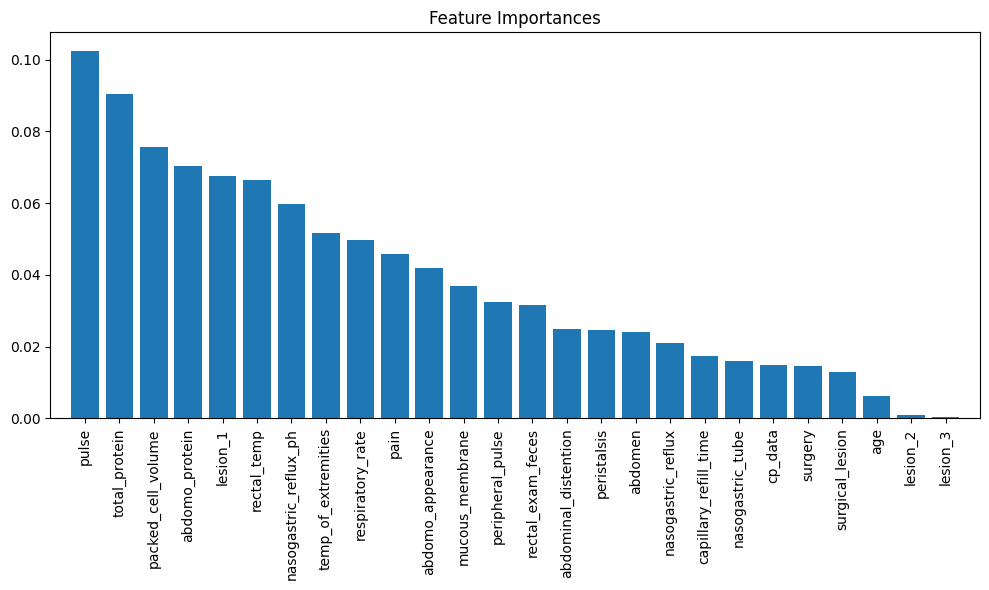

Accuracy: 0.7161290322580646
F1-Score: 0.7137215472699343
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.71      0.70        59
           1       0.73      0.52      0.61        21
           2       0.73      0.77      0.75        75

    accuracy                           0.72       155
   macro avg       0.72      0.67      0.69       155
weighted avg       0.72      0.72      0.71       155



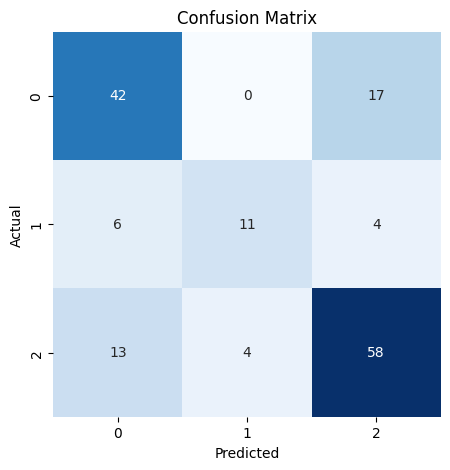

In [58]:
# Load the dataset
data = df.copy()  

# Drop rows with missing values
data.dropna(inplace=True)

# Convert categorical variables to numerical using LabelEncoder
label_encoders_rf = {}
for column in data.select_dtypes(include=['object']).columns:
    label_encoders_rf[column] = LabelEncoder()
    data[column] = label_encoders_rf[column].fit_transform(data[column])

# Split data into features and target variable
X = data.drop('outcome', axis=1)
y = data['outcome']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = rf_model.predict(X_test)


# Get feature importances
importances = rf_model.feature_importances_
features = X.columns

# Sort feature importances in descending order
indices = importances.argsort()[::-1]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), [features[i] for i in indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.tight_layout()
plt.show()

accuracy_rf = accuracy_score(y_test, y_pred)
f1_rf = f1_score(y_test, y_pred, average='weighted')

print("Accuracy:", accuracy_rf)
print("F1-Score:",f1_rf)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot heatmap
plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### *feature selection for random forest* - Reduced model

#### threashold is 0.02 

Accuracy: 0.7354838709677419
F1-Score: 0.734471853257432
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.71      0.71        59
           1       0.72      0.62      0.67        21
           2       0.76      0.79      0.77        75

    accuracy                           0.74       155
   macro avg       0.73      0.71      0.72       155
weighted avg       0.73      0.74      0.73       155



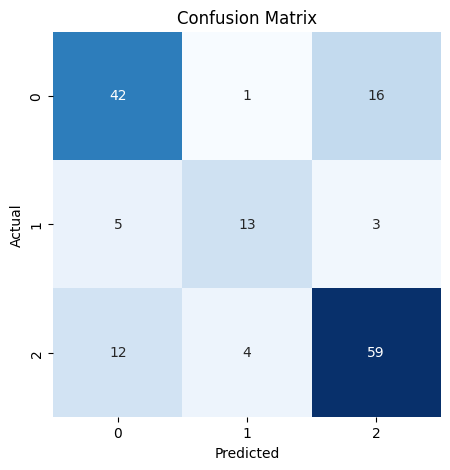

In [59]:
selected_features = features[importances > 0.02] 

# Split data into features and target variable
X = data[selected_features]
y = data['outcome']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = rf_model.predict(X_test)


accuracy_rf_reduced_model = accuracy_score(y_test, y_pred)
f1_rf_reduced_model = f1_score(y_test, y_pred, average='weighted')

print("Accuracy:", accuracy_rf_reduced_model)
print("F1-Score:",f1_rf_reduced_model)
print("Classification Report:")
print(classification_report(y_test, y_pred))


# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot heatmap
plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [60]:
! pip install xgboost

## XGBoost model

Accuracy: 0.7548387096774194
F1-Score: 0.754529189572935
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.71      0.74        59
           1       0.64      0.67      0.65        21
           2       0.78      0.81      0.80        75

    accuracy                           0.75       155
   macro avg       0.73      0.73      0.73       155
weighted avg       0.76      0.75      0.75       155



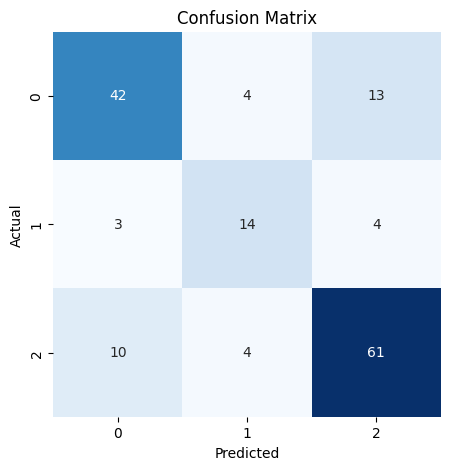

In [61]:
# Load the dataset
data = df  

# Drop rows with missing values
data.dropna(inplace=True)

# Convert categorical variables to numerical using LabelEncoder
label_encoders_xgb = {}
for column in data.select_dtypes(include=['object']).columns:
    label_encoders_xgb[column] = LabelEncoder()
    data[column] = label_encoders_xgb[column].fit_transform(data[column])

# Split data into features and target variable
X = data.drop('outcome', axis=1)
y = data['outcome']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the XGBoost model
xgb_model = XGBClassifier(objective='multi:softmax', num_class=len(set(y)), random_state=42)
xgb_model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = xgb_model.predict(X_test)

accuracy_xgb = accuracy_score(y_test, y_pred)
f1_xgb = f1_score(y_test, y_pred, average='weighted')

print("Accuracy:", accuracy_xgb)
print("F1-Score:",f1_xgb)
print("Classification Report:")
print(classification_report(y_test, y_pred))


# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot heatmap
plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [62]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 771 entries, 0 to 1233
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   surgery                771 non-null    int64  
 1   age                    771 non-null    int64  
 2   rectal_temp            771 non-null    float64
 3   pulse                  771 non-null    float64
 4   respiratory_rate       771 non-null    float64
 5   temp_of_extremities    771 non-null    int64  
 6   peripheral_pulse       771 non-null    int64  
 7   mucous_membrane        771 non-null    int64  
 8   capillary_refill_time  771 non-null    int64  
 9   pain                   771 non-null    int64  
 10  peristalsis            771 non-null    int64  
 11  abdominal_distention   771 non-null    int64  
 12  nasogastric_tube       771 non-null    int64  
 13  nasogastric_reflux     771 non-null    int64  
 14  nasogastric_reflux_ph  771 non-null    float64
 15  rectal_exa

In [63]:
testdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 824 entries, 0 to 823
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   surgery                824 non-null    object 
 1   age                    824 non-null    object 
 2   rectal_temp            824 non-null    float64
 3   pulse                  824 non-null    float64
 4   respiratory_rate       824 non-null    float64
 5   temp_of_extremities    789 non-null    object 
 6   peripheral_pulse       777 non-null    object 
 7   mucous_membrane        811 non-null    object 
 8   capillary_refill_time  818 non-null    object 
 9   pain                   795 non-null    object 
 10  peristalsis            805 non-null    object 
 11  abdominal_distention   802 non-null    object 
 12  nasogastric_tube       760 non-null    object 
 13  nasogastric_reflux     810 non-null    object 
 14  nasogastric_reflux_ph  824 non-null    float64
 15  rectal

## Neural Network model

Epoch 1/10
9/9 [==============================] - 1s 32ms/step - loss: 1.4832 - accuracy: 0.3249 - val_loss: 1.1008 - val_accuracy: 0.4194
Epoch 2/10
9/9 [==============================] - 0s 8ms/step - loss: 1.0519 - accuracy: 0.4513 - val_loss: 1.0482 - val_accuracy: 0.5000
Epoch 3/10
9/9 [==============================] - 0s 6ms/step - loss: 0.9296 - accuracy: 0.5614 - val_loss: 0.9610 - val_accuracy: 0.5323
Epoch 4/10
9/9 [==============================] - 0s 5ms/step - loss: 0.8901 - accuracy: 0.6029 - val_loss: 1.0014 - val_accuracy: 0.4677
Epoch 5/10
9/9 [==============================] - 0s 8ms/step - loss: 0.8525 - accuracy: 0.6408 - val_loss: 0.9786 - val_accuracy: 0.5806
Epoch 6/10
9/9 [==============================] - 0s 6ms/step - loss: 0.8363 - accuracy: 0.6245 - val_loss: 0.9792 - val_accuracy: 0.5968
Epoch 7/10
9/9 [==============================] - 0s 6ms/step - loss: 0.8109 - accuracy: 0.6498 - val_loss: 0.9395 - val_accuracy: 0.5484
Epoch 8/10
9/9 [=================

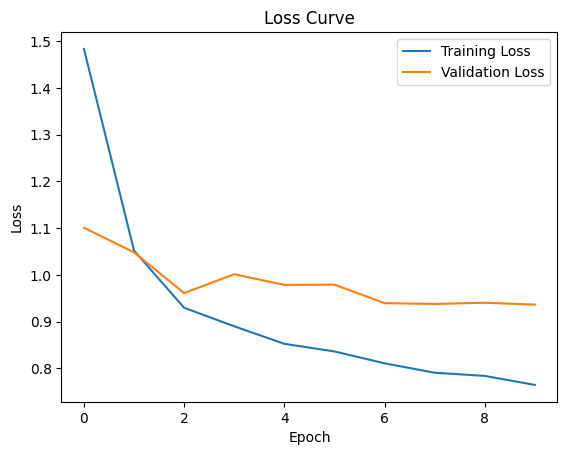

5/5 [==============================] - 0s 2ms/step - loss: 0.7806 - accuracy: 0.6452
Accuracy: 0.6451612710952759
5/5 [==============================] - 0s 2ms/step
F1 Score: 0.63914357191905


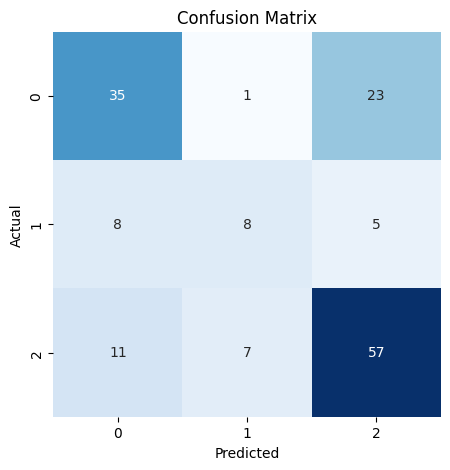

In [64]:
# Load the dataset
data = df.copy()

# Drop rows with missing values
data.dropna(inplace=True)

# Convert categorical variables to numerical using LabelEncoder
label_encoders_nn = {}
for column in data.select_dtypes(include=['object']).columns:
    label_encoders_nn[column] = LabelEncoder()
    data[column] = label_encoders_nn[column].fit_transform(data[column])

# Split data into features and target variable
X = data.drop('outcome', axis=1)
y = data['outcome']

# Convert target variable to categorical
y_categorical = to_categorical(y)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

# Build the neural network model
model = Sequential([
    Dense(64, input_dim=X_train.shape[1], activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(len(set(y)), activation='softmax')
])

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.1)

# Plot the loss curve
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

# Evaluate the model
_, accuracy_nm = model.evaluate(X_test, y_test)
print("Accuracy:", accuracy_nm)

# Make predictions on the testing set
y_pred = model.predict(X_test)
y_pred_classes = [round(pred.argmax()) for pred in y_pred]

# Calculate F1 score
f1_nm = classification_report(y_test.argmax(axis=1), y_pred_classes, output_dict=True)['weighted avg']['f1-score']
print("F1 Score:", f1_nm)

# Create a confusion matrix
conf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred_classes)

# Plot heatmap
plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## **Model evaluation for best model**

In [65]:
accuracy = [accuracy_svm, accuracy_logistic, accuracy_rf, accuracy_rf_reduced_model, accuracy_xgb, accuracy_nm]
f1_score = [f1_svm, f1_logistic, f1_rf, f1_rf_reduced_model, f1_xgb, f1_nm]

Models = ["SVM", "Logistic", "Random Forest", "Random Forest - Reduced", "XGBoost", "Neural Network-sq"]

model_table = pd.DataFrame({"Model": Models, "Accuracy": accuracy, "F1-Score": f1_score})

# Find the index of the row with the maximum F1-score
best_model_index = model_table["F1-Score"].idxmax()

# Create a new DataFrame with the best model highlighted
highlighted_model_table = model_table.style.apply(lambda x: ["background: lightgreen" if x.name == best_model_index else "" for i in x], axis=1)

highlighted_model_table

,Model,Accuracy,F1-Score
0,SVM,0.703226,0.697697
1,Logistic,0.683871,0.679724
2,Random Forest,0.716129,0.713722
3,Random Forest - Reduced,0.735484,0.734472
4,XGBoost,0.754839,0.754529
5,Neural Network-sq,0.645161,0.639144


### ***Saving the model***

In [66]:
label_encoders

{'surgery': LabelEncoder(),
 'age': LabelEncoder(),
 'temp_of_extremities': LabelEncoder(),
 'peripheral_pulse': LabelEncoder(),
 'mucous_membrane': LabelEncoder(),
 'capillary_refill_time': LabelEncoder(),
 'pain': LabelEncoder(),
 'peristalsis': LabelEncoder(),
 'abdominal_distention': LabelEncoder(),
 'nasogastric_tube': LabelEncoder(),
 'nasogastric_reflux': LabelEncoder(),
 'rectal_exam_feces': LabelEncoder(),
 'abdomen': LabelEncoder(),
 'abdomo_appearance': LabelEncoder(),
 'surgical_lesion': LabelEncoder(),
 'lesion_1': LabelEncoder(),
 'lesion_2': LabelEncoder(),
 'lesion_3': LabelEncoder(),
 'cp_data': LabelEncoder(),
 'outcome': LabelEncoder()}

In [67]:
# Save the label encoders
joblib.dump(label_encoders, "label_encoders.pkl")
print("label_encoders saved successfully as", "encoded")


# Save the trained model to a file
filename = 'xgboost_model.pkl'
pickle.dump(xgb_model, open(filename, 'wb'))

print("XGBoost model saved successfully as", filename)

label_encoders saved successfully as encoded
XGBoost model saved successfully as xgboost_model.pkl


# Making predictions for new test data

In [68]:
lesion_columns = ['lesion_1', 'lesion_2', 'lesion_3']

for column in lesion_columns:
    if testdata[column].dtype == 'int64':
        testdata[column] = testdata[column].astype('object')
        
# Label encode categorical variables
label_encoders = {}  # Store label encoders for each categorical column
categorical_columns = testdata.select_dtypes(include=['object']).columns
for column in categorical_columns:
    label_encoders[column] = LabelEncoder()
    testdata[column] = label_encoders[column].fit_transform(testdata[column])

# Make predictions on the preprocessed testdata
predictions = xgb_model.predict(testdata)

# Map numerical predictions to their original labels
prediction_labels = {0: 'died', 1: 'euthanized', 2: 'lived'}

# Convert numerical predictions to their corresponding labels
original_predictions_labels = [prediction_labels[prediction] for prediction in predictions]

# Print the original predictions
print(original_predictions_labels)

['lived', 'lived', 'lived', 'euthanized', 'lived', 'lived', 'lived', 'lived', 'lived', 'lived', 'died', 'lived', 'euthanized', 'lived', 'died', 'lived', 'lived', 'died', 'died', 'died', 'died', 'died', 'died', 'lived', 'died', 'died', 'lived', 'euthanized', 'lived', 'died', 'lived', 'died', 'died', 'lived', 'lived', 'died', 'lived', 'lived', 'lived', 'euthanized', 'died', 'euthanized', 'died', 'lived', 'lived', 'died', 'died', 'lived', 'lived', 'lived', 'died', 'lived', 'died', 'lived', 'lived', 'lived', 'died', 'died', 'died', 'lived', 'died', 'died', 'died', 'died', 'died', 'lived', 'euthanized', 'died', 'lived', 'lived', 'died', 'lived', 'lived', 'lived', 'euthanized', 'died', 'euthanized', 'died', 'lived', 'died', 'died', 'euthanized', 'lived', 'lived', 'lived', 'lived', 'lived', 'euthanized', 'lived', 'lived', 'euthanized', 'lived', 'died', 'euthanized', 'lived', 'euthanized', 'lived', 'died', 'died', 'died', 'died', 'lived', 'lived', 'lived', 'lived', 'euthanized', 'died', 'eutha

## Preparing submission dataset

In [69]:
submissiondata['outcome'] = original_predictions_labels

In [70]:
submissiondata.to_csv('submission.csv')
submissiondata

,id,outcome
0,1235,lived
1,1236,lived
2,1237,lived
3,1238,euthanized
4,1239,lived
...,...,...
819,2054,died
820,2055,euthanized
821,2056,died
822,2057,lived


## For the easiness of building the web app, the following code was used for xgboost model fitting using lesion_1,lesion_2 and lesion_3 as numerical variables.

**Note :**

> # There is no considerable change in accuracy when treating above variables as numericals. :76%

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1235 entries, 0 to 1234
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   surgery                1235 non-null   object 
 1   age                    1235 non-null   object 
 2   rectal_temp            1235 non-null   float64
 3   pulse                  1235 non-null   float64
 4   respiratory_rate       1235 non-null   float64
 5   temp_of_extremities    1196 non-null   object 
 6   peripheral_pulse       1175 non-null   object 
 7   mucous_membrane        1214 non-null   object 
 8   capillary_refill_time  1229 non-null   object 
 9   pain                   1191 non-null   object 
 10  peristalsis            1215 non-null   object 
 11  abdominal_distention   1212 non-null   object 
 12  nasogastric_tube       1155 non-null   object 
 13  nasogastric_reflux     1214 non-null   object 
 14  nasogastric_reflux_ph  1235 non-null   float64
 15  rect

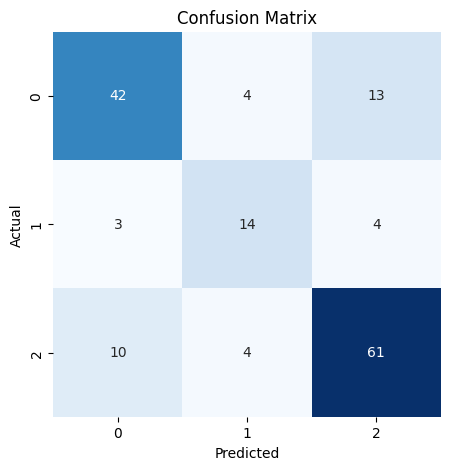

label_encoders saved successfully as label_encoders_new
XGBoost model saved successfully as xgboost_model_new.pkl


In [72]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score,confusion_matrix


trainset = pd.read_csv('/kaggle/input/playground-series-s3e22/train.csv')
trainset.columns

trainset = trainset.drop(['id','hospital_number'], axis =1)

trainset.info()

# =============================================================================
# lesion_columns = ['lesion_1', 'lesion_2', 'lesion_3']
# 
# def convert_int_to_object(data, columns):
#     for column in columns:
#         if data[column].dtype == 'int64':
#             data[column] = data[column].astype('object')
# 
# # Applying the function to traindata
# convert_int_to_object(trainset, lesion_columns)
# =============================================================================

trainset.isnull().sum()

trainset.dropna(inplace = True)

for i in trainset.select_dtypes(include=['object']).columns:
    print(i , ": ",trainset[i].unique())

# Convert categorical variables to numerical using LabelEncoder
label_encoders = {}
for column in trainset.select_dtypes(include=['object']).columns:
    label_encoders[column] = LabelEncoder()
    trainset[column] = label_encoders[column].fit_transform(trainset[column])

# Split data into features and target variable
X = trainset.drop('outcome', axis=1)
y = trainset['outcome']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the XGBoost model
xgb_model = XGBClassifier(objective='multi:softmax', num_class=len(set(y)), random_state=42)
xgb_model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = xgb_model.predict(X_test)

accuracy_xgb = accuracy_score(y_test, y_pred)
f1_xgb = f1_score(y_test, y_pred, average='weighted')

print("Accuracy:", accuracy_xgb)
print("F1-Score:",f1_xgb)
print("Classification Report:")
print(classification_report(y_test, y_pred))


# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot heatmap
plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show() 


import pickle
import joblib
# Save the label encoders
joblib.dump(label_encoders, "label_encoders_new.pkl")
print("label_encoders saved successfully as", "label_encoders_new")


# Save the trained model to a file
filename = 'xgboost_model_new.pkl'
pickle.dump(xgb_model, open(filename, 'wb'))

print("XGBoost model saved successfully as", filename)